In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

In [124]:
test_df = pd.read_csv('~/grive/InsightDataScience/Pricing_Test/test_results.csv')
print len(test_df)
test_df.head()

316800


,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [125]:
# delete the wrong timestamp samples where min and sec are not in 0~59
test_df['min'] = test_df['timestamp'].apply(lambda x: int(x[14:16]))
test_df['sec'] = test_df['timestamp'].apply(lambda x: int(x[17:19]))
test_df=test_df.drop(test_df.index[test_df['min'] > 59])
test_df=test_df.drop(test_df.index[test_df['sec'] > 59])
test_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,min,sec
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,38,34
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,8,46
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,1,23
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,26,1
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,4,40


In [127]:
days = max(pd.to_datetime(test_df['timestamp']))-min(pd.to_datetime(test_df['timestamp'])) #when 100 error min not in 0~59
print days

90 days 23:55:33


In [128]:
user_df = pd.read_csv('~/grive/InsightDataScience/Pricing_Test/user_table.csv')
print len(user_df)
user_df.head()

275616


,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [129]:
df = test_df.merge(user_df,left_on='user_id',right_on='user_id',how='inner')
print len(df)
df.head()

266656


,user_id,timestamp,source,device,operative_system,test,price,converted,min,sec,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,38,34,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,8,46,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,1,23,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,26,1,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,4,40,Fishers,USA,39.95,-86.02


In [130]:
# confirm that the AB testing group percentage for the test table.
print 'The total user number is %d. The number of price $39 and $59 are %d %d, respectively.' % (len(test_df), len(test_df.index[test_df['price']==39]), len(test_df.index[test_df['price']==59]))
print 'The percentage of B group to A group in this AB testing is %.2f and %.2f percent.' % (float(len(test_df.index[test_df['price']==39]))/len(test_df)*100, float(len(test_df.index[test_df['price']==59]))/len(test_df)*100)
print 'The number of users converted is %d, which is %.2f percent.' %(len(test_df.index[test_df['converted']==1]), float(len(test_df.index[test_df['converted']==1]))/len(test_df)*100)

The total user number is 306529. The number of price $39 and $59 are 196019 110510, respectively.
The percentage of B group to A group in this AB testing is 63.95 and 36.05 percent.
The number of users converted is 5620, which is 1.83 percent.


In [131]:
# Get the same information for the joined table for which customers information is available.
print 'The total user number is %d. The number of price $39 and $59 are %d %d, respectively.' % (len(df), len(df.index[df['price']==39]), len(df.index[df['price']==59]))
print 'The percentage of B group to A group in this AB testing is %.2f and %.2f percent.' % (float(len(df.index[df['price']==39]))/len(df)*100, float(len(df.index[df['price']==59]))/len(df)*100)
print 'The number of users converted is %d, which is %.2f percent.' %(len(df.index[df['converted']==1]), float(len(df.index[df['converted']==1]))/len(df)*100)

The total user number is 266656. The number of price $39 and $59 are 170563 96093, respectively.
The percentage of B group to A group in this AB testing is 63.96 and 36.04 percent.
The number of users converted is 4856, which is 1.82 percent.


In [132]:
# know how many useres per operative_system
df.groupby('operative_system').agg({'test':{'num_os':len}})

,test
,num_os
operative_system,
android,63055
iOS,80373
linux,3508
mac,21175
other,13682
windows,84863


In [133]:
df_converted = df[df['converted']==1]
df_not_converted = df[df['converted']==0]

In [163]:
df_A = df[df['price']==39]
df_B = df[df['price']==59]
print 'The number of users converted in A test group is %d, which is %.2f percent.' %(len(df_A.index[df_A['converted']==1]), float(len(df_A.index[df_A['converted']==1]))/len(df_A)*100)
print 'The number of users converted in B test group is %d, which is %.2f percent.' %(len(df_B.index[df_B['converted']==1]), float(len(df_B.index[df_B['converted']==1]))/len(df_B)*100)
rev_delta = len(df_B.index[df_B['converted']==1])*59-(float(len(df_A.index[df_A['converted']==1]))/len(df_A)*len(df_B))*39
rev_percent = rev_delta/((float(len(df_A.index[df_A['converted']==1])))/len(df_A)*len(df_B)*39)
print 'The increased revenue by increasing price from 39 to 59 dollars is %.2f dollars and %.2f percent.' %  (rev_delta, rev_percent*100)

The number of users converted in A test group is 3376, which is 1.98 percent.
The number of users converted in B test group is 1480, which is 1.54 percent.
The increased revenue by increasing price from 39 to 59 dollars is 13142.20 dollars and 17.72 percent.


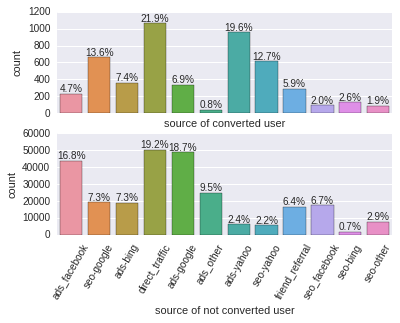

In [134]:
%matplotlib inline

plt.subplot(2, 1, 1)
ncount = len(df_converted)
ax1 = sns.countplot(x='source',data = df_converted)
for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') 
plt.xticks([])
plt.xlabel('source of converted user')
plt.subplot(2, 1, 2)
ncount = len(df_not_converted)
ax2 = sns.countplot(x='source',data = df_not_converted)
for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') 
plt.xticks(rotation = 60)
plt.xlabel('source of not converted user')
plt.show()

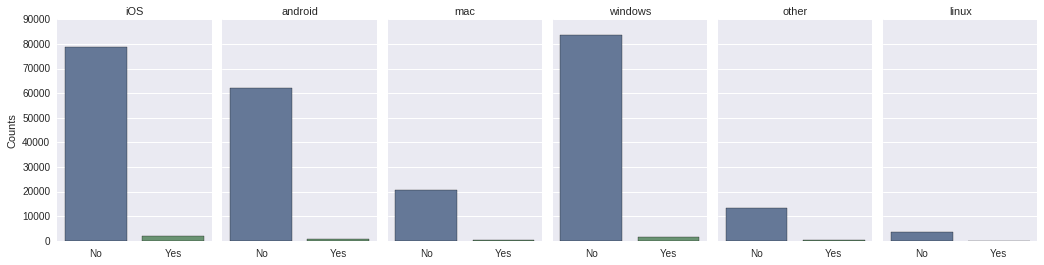

In [150]:
g = sns.factorplot("converted", col="operative_system",
...                    data=df, saturation=.5,
...                    kind="count", ci=None, aspect=.6)

(g.set_axis_labels("", "Counts")
...   .set_xticklabels(["No", "Yes"])
...   .set_titles("{col_name}")
...   .despine(left=True))

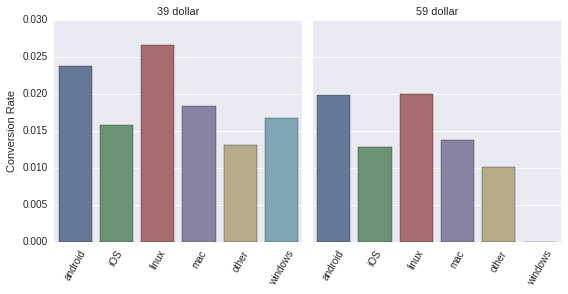

In [138]:
g = sns.factorplot(x="operative_system",y="converted", col="price",
...                    data=df, saturation=.5,
...                    kind="bar", ci=None)

(g.set_axis_labels("", "Conversion Rate")
...   .set_xticklabels(["android", "iOS","linux","mac","other","windows"],rotation = 60)
...   .set_titles("{col_name} dollar")
...   .despine(left=True))

In [140]:
num_feats=['source','operative_system','price','city']
X = df[num_feats]
y = df['converted']
X.head()

,source,operative_system,price,city
0,ads_facebook,iOS,39,Buffalo
1,seo-google,android,39,Lakeville
2,ads-bing,android,39,Parma
3,direct_traffic,iOS,59,Fayetteville
4,ads_facebook,mac,39,Fishers


In [159]:
n=30
faster_df = df.drop(df.index[pd.to_datetime(df['timestamp'])> (min(pd.to_datetime(df['timestamp']))+timedelta(days=n))])
print 'The sample number within %d days of experiment is %d and %.2f percent of the total samples.' % (n, len(faster_df), float(len(faster_df))/len(df)*100)
faster_df.head()

The sample number within 30 days of experiment is 84773 and 31.79 percent of the total samples.


,user_id,timestamp,source,device,operative_system,test,price,converted,min,sec,city,country,lat,long
6,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1,19,29,East Orange,USA,40.77,-74.21
7,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0,28,10,Dayton,USA,39.78,-84.20
11,460593,2015-03-21 09:43:51,friend_referral,mobile,iOS,0,39,1,43,51,Hampton,USA,37.05,-76.29
13,552048,2015-03-22 08:58:32,ads-bing,web,windows,1,59,0,58,32,Culver City,USA,34.01,-118.40
14,444108,2015-03-16 12:20:49,seo-google,web,mac,0,39,0,20,49,Milwaukee,USA,43.06,-87.97


In [165]:
faster_df_A = faster_df[faster_df['price']==39]
faster_df_B = faster_df[faster_df['price']==59]
print 'The number of users converted in A test group is %d, which is %.2f percent.' %(len(faster_df_A.index[faster_df_A['converted']==1]), float(len(faster_df_A.index[faster_df_A['converted']==1]))/len(faster_df_A)*100)
print 'The number of users converted in B test group is %d, which is %.2f percent.' %(len(faster_df_B.index[faster_df_B['converted']==1]), float(len(faster_df_B.index[faster_df_B['converted']==1]))/len(faster_df_B)*100)
rev_delta = len(faster_df_B.index[faster_df_B['converted']==1])*59-(float(len(faster_df_A.index[faster_df_A['converted']==1]))/len(faster_df_A)*len(faster_df_B))*39
rev_percent = rev_delta/((float(len(faster_df_A.index[faster_df_A['converted']==1])))/len(faster_df_A)*len(faster_df_B)*39)
print 'The increased revenue by increasing price from 39 to 59 dollars is %.2f dollars and %.2f percent after %d days of experiment.' %  (rev_delta, rev_percent*100,n)

The number of users converted in A test group is 1045, which is 1.93 percent.
The number of users converted in B test group is 504, which is 1.64 percent.
The increased revenue by increasing price from 39 to 59 dollars is 6636.28 dollars and 28.73 percent after 30 days of experiment.


In [180]:
rev_del = []
rev_perc = []
days = []
for i in np.arange(10,100,10):
    new_df = df.drop(df.index[pd.to_datetime(df['timestamp'])> (min(pd.to_datetime(df['timestamp']))+timedelta(days=i))])
    new_df_A = new_df[new_df['price']==39]
    new_df_B = new_df[new_df['price']==59]
    delta = len(new_df_B.index[new_df_B['converted']==1])*59-(float(len(new_df_A.index[new_df_A['converted']==1]))/len(new_df_A)*len(new_df_B))*39
    rev_del.append(round(delta,2))
    rev_perc.append(delta/((float(len(new_df_A.index[new_df_A['converted']==1]))/len(new_df_A)*len(new_df_B))*39))
    days.append(i)

In [181]:
time_exp = pd.DataFrame()
time_exp['days'] = days
time_exp['rev_inc'] = rev_del
time_exp['rev_inc_perc'] = rev_perc
time_exp.head()

,days,rev_inc,rev_inc_perc
0,10,1560.93,0.209069
1,20,4597.50,0.287460
2,30,6636.28,0.287288
3,40,7325.78,0.232592
4,50,7185.21,0.178511


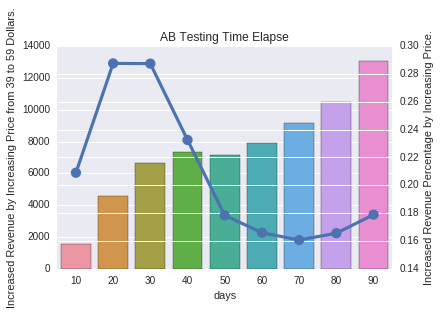

In [182]:
ax1 = sns.barplot(x='days',y = 'rev_inc', data = time_exp)
ax1.set_ylabel('Increased Revenue by Increasing Price from 39 to 59 Dollars.')
ax2 = plt.twinx(ax1)
sns.pointplot(x='days', y = 'rev_inc_perc',data = time_exp, ax=ax2)
ax2.set_ylabel('Increased Revenue Percentage by Increasing Price.')
plt.title('AB Testing Time Elapse')